In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
df = pd.read_csv("dataset_log_suavizado.csv")
df['Fecha'] = pd.to_datetime(df['Fecha'])

print("--- Generando Nuevas Features ---")

df['Descuento_Pct'] = (df['Precio_base'] - df['Precio_Prom_Venta']) / df['Precio_base']
df['Descuento_Pct'] = df['Descuento_Pct'].clip(lower=0) # Eliminar negativos

df['Mes'] = df['Fecha'].dt.month
df['Mes_Sin'] = np.sin(2 * np.pi * df['Mes'] / 12)
df['Mes_Cos'] = np.cos(2 * np.pi * df['Mes'] / 12)

df['Tendencia_6Q'] = df.groupby('SKU')['Demanda_Log'].transform(
    lambda x: x.rolling(window=6, min_periods=1).mean().shift(1)
).fillna(0)

# Actualizamos df_final
df_final = df.copy()

print("✅ Nuevas features agregadas:")
print(df_final[['SKU', 'Fecha', 'Descuento_Pct', 'Mes_Sin', 'Tendencia_6Q']].head())

--- Generando Nuevas Features ---
✅ Nuevas features agregadas:
        SKU      Fecha  Descuento_Pct   Mes_Sin  Tendencia_6Q
0  SKU-0001 2025-01-05       0.003750  0.500000      0.000000
1  SKU-0001 2025-01-19       0.014737  0.500000      3.891820
2  SKU-0001 2025-02-02       0.035094  0.866025      4.133789
3  SKU-0001 2025-02-16       0.054595  0.866025      4.280763
4  SKU-0001 2025-03-02       0.071042  1.000000      4.396805


In [ ]:
INPUT_WIDTH = 6   # Ver 6 quincenas hacia atrás
LABEL_WIDTH = 6   # Predecir 6 quincenas hacia adelante

FEATURES = [
    'Demanda_Log',          
    'Precio_Prom_Venta', 
    'Num_Transacciones', 
    'Num_Feriados',
    'Num_Dias_Pago',
    'Num_Dias_Promocion',
    'Descuento_Pct',        
    'Mes_Sin',              
    'Mes_Cos',              
    'Tendencia_6Q'          
]

# El target sigue siendo el Logaritmo de la demanda
TARGET_COL = 'Demanda_Log' 

# --- ESCALADO ---
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Copia para escalar
df_scaled = df_final.copy()

# Ajustamos scalers
df_scaled[FEATURES] = scaler_x.fit_transform(df_final[FEATURES])
df_scaled[[TARGET_COL]] = scaler_y.fit_transform(df_final[[TARGET_COL]])

#FUNCIÓN DE SECUENCIAS MULTI-STEP
def create_multistep_sequences(data, features, target_col, input_steps, output_steps):
    X, Y = [], []
    
    for sku, group in data.groupby('SKU'):
        data_features = group[features].values
        data_target = group[target_col].values

        total_steps = len(group)
        for i in range(total_steps - input_steps - output_steps + 1):

            X.append(data_features[i : i + input_steps])
            
            Y.append(data_target[i + input_steps : i + input_steps + output_steps])
            
    return np.array(X), np.array(Y)

X, Y = create_multistep_sequences(df_scaled, FEATURES, TARGET_COL, INPUT_WIDTH, LABEL_WIDTH)

train_size = int(len(X) * 0.80)
val_size = int(len(X) * 0.10)

X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:train_size+val_size], Y[train_size:train_size+val_size]
X_test, Y_test = X[train_size+val_size:], Y[train_size+val_size:]

print(f"Formatos listos para Multi-Step:")
print(f"X_train: {X_train.shape} (Muestras, 6 Pasos, {len(FEATURES)} Features)")
print(f"Y_train: {Y_train.shape} (Muestras, 6 Pasos a predecir)")

Formatos listos para Multi-Step:
X_train: (9880, 6, 10) (Muestras, 6 Pasos, 10 Features)
Y_train: (9880, 6) (Muestras, 6 Pasos a predecir)


In [6]:
# Convertir a Tensores
train_data = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
val_data = TensorDataset(torch.Tensor(X_val), torch.Tensor(Y_val))
test_data = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

batch_size = 64
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [ ]:
#ARQUITECTURA GRU MULTI-STEP
class GRUMultiStep(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_steps, dropout_prob):
        super(GRUMultiStep, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        
        self.fc = nn.Linear(hidden_size, output_steps)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

In [ ]:
INPUT_SIZE = len(FEATURES) 
HIDDEN_SIZE = 128
NUM_LAYERS = 3
OUTPUT_STEPS = 6 
DROPOUT_PROB = 0.5
LEARNING_RATE = 0.0003
NUM_EPOCHS = 500
CLIP_VALUE = 1.0
PATIENCE = 20

#INSTANCIAR MODELO MULTI-STEP
model = GRUMultiStep(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_STEPS, DROPOUT_PROB)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Iniciando entrenamiento Multi-Step (Prediciendo {OUTPUT_STEPS} Qs)...")

#VARIABLES DE HISTORIAL
history_loss = []
history_val_loss = []
history_r2_score = [] 

best_val_loss = float('inf') 
patience_counter = 0
best_model_weights = None 

#BUCLE DE ENTRENAMIENTO
for epoch in range(NUM_EPOCHS):
    
    # 1. Fase de Entrenamiento
    model.train()
    epoch_train_loss = 0.0
    for batch_X, batch_Y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_Y)
        
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)

        optimizer.step()
        epoch_train_loss += loss.item()
        
    avg_train_loss = epoch_train_loss / len(train_loader)
    history_loss.append(avg_train_loss)

    # 2. Fase de Validación
    model.eval()
    epoch_val_loss = 0.0

    all_y_val = []
    all_outputs_val = []
    
    with torch.no_grad():
        for batch_X_val, batch_Y_val in val_loader:
            outputs_val = model(batch_X_val)
            loss_val = criterion(outputs_val, batch_Y_val)
            epoch_val_loss += loss_val.item()
            
            # Guardamos para R² (en CPU)
            all_y_val.append(batch_Y_val.cpu())
            all_outputs_val.append(outputs_val.cpu())
            
    avg_val_loss = epoch_val_loss / len(val_loader)
    history_val_loss.append(avg_val_loss)
    
    # 3. Calcular R² Global (Multi-Step)
    all_y_val = torch.cat(all_y_val).numpy()
    all_outputs_val = torch.cat(all_outputs_val).numpy()
    
    # Opcional: R2 promedio sobre todos los pasos
    r2 = r2_score(all_y_val.flatten(), all_outputs_val.flatten())
    history_r2_score.append(r2)
    
    # Imprimir progreso
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss(Train): {avg_train_loss:.5f}, Loss(Val): {avg_val_loss:.5f}, R² (Val): {r2:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0 

        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"   -> Mejorado. Guardando en memoria...")
    else:
        patience_counter += 1
        
    if patience_counter >= PATIENCE:
        print(f"\n¡Early Stopping activado en la época {epoch+1}!")
        print(f"La pérdida de validación no mejoró por {PATIENCE} épocas.")
        break 

if best_model_weights:
    print("\nCargando pesos del mejor modelo guardado en la variable 'model'.")
    model.load_state_dict(best_model_weights)

print("Entrenamiento completado.")
print("👉 AHORA: Ejecuta tu celda de guardado manual para salvar el archivo.")

Iniciando entrenamiento Multi-Step (Prediciendo 6 Qs)...
Epoch [1/500], Loss(Train): 0.01805, Loss(Val): 0.01083, R² (Val): 0.0528
   -> Mejorado. Guardando en memoria...
Epoch [2/500], Loss(Train): 0.00847, Loss(Val): 0.00943, R² (Val): 0.1751
   -> Mejorado. Guardando en memoria...
Epoch [3/500], Loss(Train): 0.00812, Loss(Val): 0.00904, R² (Val): 0.2088
   -> Mejorado. Guardando en memoria...
Epoch [4/500], Loss(Train): 0.00783, Loss(Val): 0.00867, R² (Val): 0.2431
   -> Mejorado. Guardando en memoria...
Epoch [5/500], Loss(Train): 0.00767, Loss(Val): 0.00847, R² (Val): 0.2595
   -> Mejorado. Guardando en memoria...
Epoch [6/500], Loss(Train): 0.00754, Loss(Val): 0.00865, R² (Val): 0.2422
Epoch [7/500], Loss(Train): 0.00738, Loss(Val): 0.00848, R² (Val): 0.2572
Epoch [8/500], Loss(Train): 0.00734, Loss(Val): 0.00831, R² (Val): 0.2722
   -> Mejorado. Guardando en memoria...
Epoch [9/500], Loss(Train): 0.00728, Loss(Val): 0.00890, R² (Val): 0.2194
Epoch [10/500], Loss(Train): 0.00723,

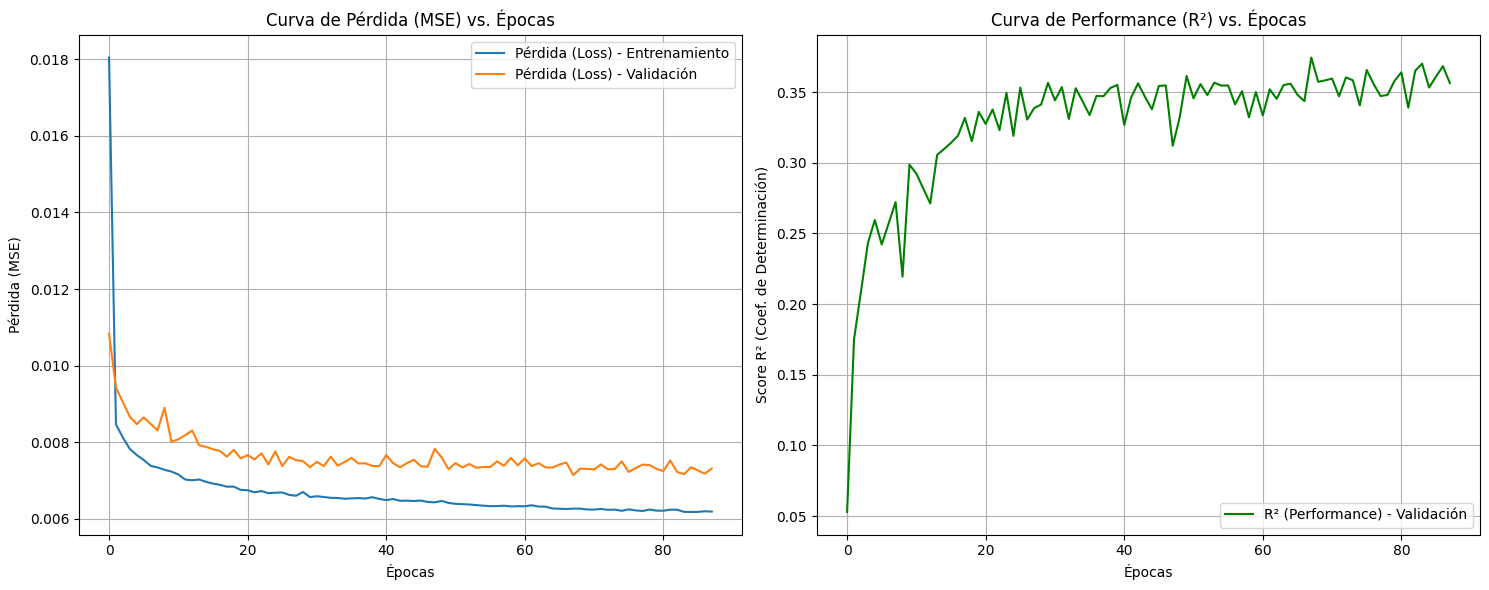

In [10]:
plt.figure(figsize=(15, 6))

#(MSE)
plt.subplot(1, 2, 1) 
plt.plot(history_loss, label='Pérdida (Loss) - Entrenamiento')
plt.plot(history_val_loss, label='Pérdida (Loss) - Validación')
plt.title('Curva de Pérdida (MSE) vs. Épocas')
plt.ylabel('Pérdida (MSE)')
plt.xlabel('Épocas')
plt.legend(loc='upper right')
plt.grid(True)

# Curva de Performance
plt.subplot(1, 2, 2) 
plt.plot(history_r2_score, label='R² (Performance) - Validación', color='green')
plt.title('Curva de Performance (R²) vs. Épocas')
plt.ylabel('Score R² (Coef. de Determinación)')
plt.xlabel('Épocas')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout() 
plt.show()


Métricas Finales del Modelo
  Score R² (Test):     0.5480
  Error (MAE Test):    1.5257 (Unidades de Demanda)
  Error (RMSE Test):   2.0273 (Unidades de Demanda)

El MAE significa que, en promedio, las predicciones del modelo
se desvían en 1.53 unidades de la demanda real.


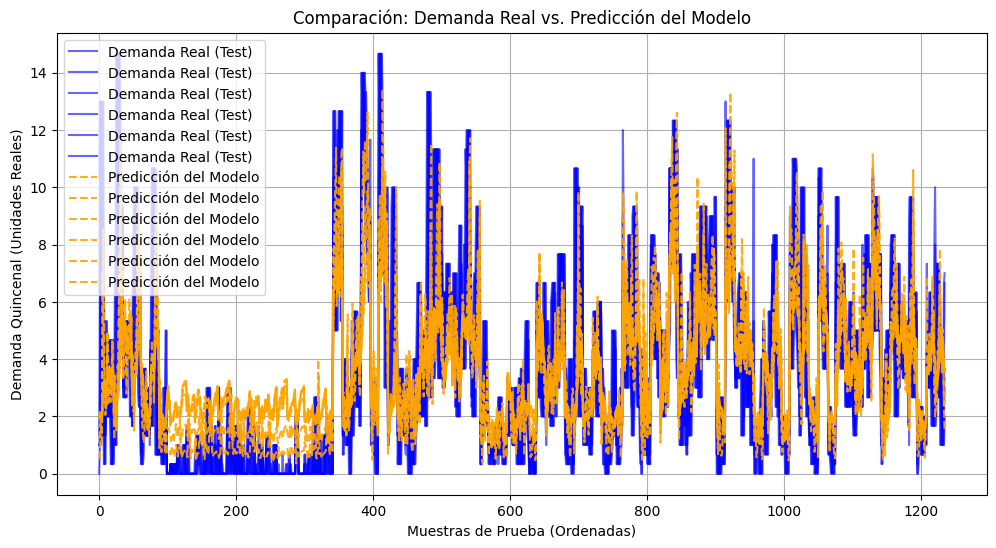

In [11]:
model.eval() 

all_y_test = []
all_outputs_test = []

with torch.no_grad(): 
    for batch_X_test, batch_Y_test in test_loader:
        outputs_test = model(batch_X_test)
        all_y_test.append(batch_Y_test.cpu())
        all_outputs_test.append(outputs_test.cpu())

all_y_test = torch.cat(all_y_test).numpy()
all_outputs_test = torch.cat(all_outputs_test).numpy()

#Deshacer escalado
y_test_log = scaler_y.inverse_transform(all_y_test)
y_pred_log = scaler_y.inverse_transform(all_outputs_test)

#Deshacer el logaritmo
y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)

test_mse = mean_squared_error(y_test_real, y_pred_real)
test_rmse = np.sqrt(test_mse) 
test_mae = mean_absolute_error(y_test_real, y_pred_real)
test_r2 = r2_score(y_test_real, y_pred_real)

print("\nMétricas Finales del Modelo")
print(f"  Score R² (Test):     {test_r2:.4f}")
print(f"  Error (MAE Test):    {test_mae:.4f} (Unidades de Demanda)")
print(f"  Error (RMSE Test):   {test_rmse:.4f} (Unidades de Demanda)")
print("\nEl MAE significa que, en promedio, las predicciones del modelo")
print(f"se desvían en {test_mae:.2f} unidades de la demanda real.")

# Gráfica de Comparación
plt.figure(figsize=(12, 6))
plt.plot(y_test_real, label='Demanda Real (Test)', color='blue', alpha=0.6)
plt.plot(y_pred_real, label='Predicción del Modelo', color='orange', linestyle='--', alpha=0.9)
plt.title('Comparación: Demanda Real vs. Predicción del Modelo')
plt.ylabel('Demanda Quincenal (Unidades Reales)')
plt.xlabel('Muestras de Prueba (Ordenadas)')
plt.legend()
plt.grid(True)
plt.show()


El MAE significa que, en promedio, las predicciones del modelo
se desvían en 1.53 unidades de la demanda real.


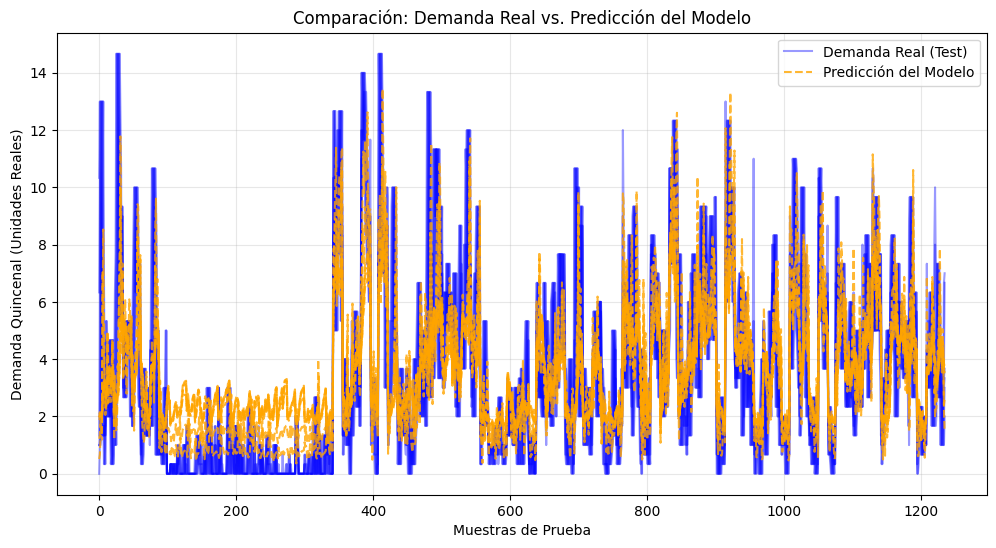

In [12]:
import matplotlib.pyplot as plt

print("\nEl MAE significa que, en promedio, las predicciones del modelo")
print(f"se desvían en {test_mae:.2f} unidades de la demanda real.")

plt.figure(figsize=(12, 6))

plt.plot(y_test_real, label='Demanda Real (Test)', color='blue', alpha=0.4)
plt.plot(y_pred_real, label='Predicción del Modelo', color='orange', linestyle='--', alpha=0.8)

plt.title('Comparación: Demanda Real vs. Predicción del Modelo')
plt.ylabel('Demanda Quincenal (Unidades Reales)')
plt.xlabel('Muestras de Prueba')
plt.grid(True, alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()

by_label = dict(zip(labels, handles))

plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.show()

In [13]:
import torch

NOMBRE_DEL_ARCHIVO = "Etapa6_GRU_MultiStep_Model.pth"

# --- GUARDAR ---
# Guardamos los pesos del modelo que está actualmente en memoria
try:
    torch.save(model.state_dict(), NOMBRE_DEL_ARCHIVO)
    print(f"✅ ¡Modelo guardado exitosamente!")
    print(f"📂 Nombre del archivo: {NOMBRE_DEL_ARCHIVO}")
    print("Guárdalo bien, este es tu 'Cerebro' entrenado.")
except NameError:
    print("⚠️ Error: No se encontró la variable 'model'. Asegúrate de haber terminado el entrenamiento.")

✅ ¡Modelo guardado exitosamente!
📂 Nombre del archivo: Etapa6_GRU_MultiStep_Model.pth
Guárdalo bien, este es tu 'Cerebro' entrenado.


c:\Users\agabr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


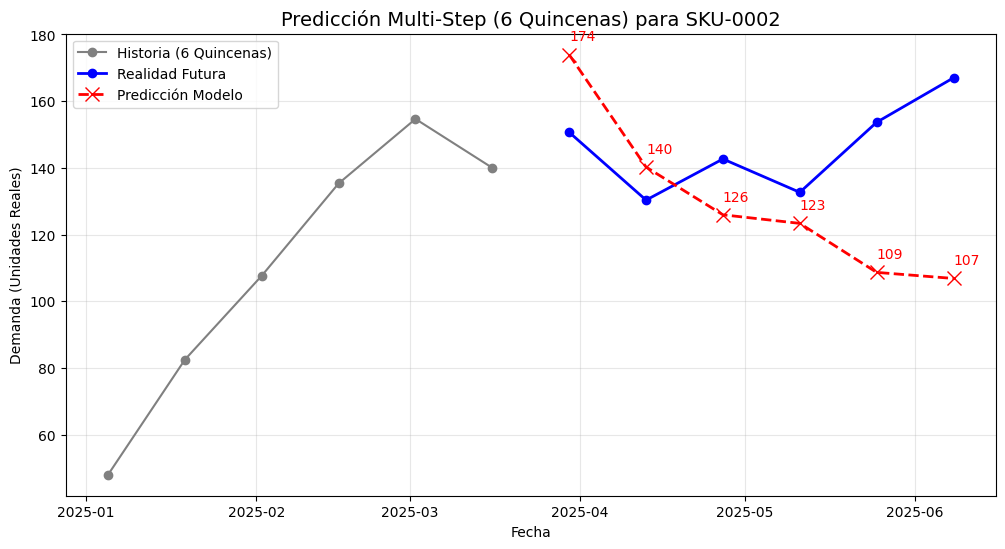


--- RESULTADOS NUMÉRICOS (SKU-0002) ---
Fechas Predichas: ['2025-03-30', '2025-04-13', '2025-04-27', '2025-05-11', '2025-05-25', '2025-06-08']
Predicción: [173, 140, 125, 123, 108, 106]
Realidad:   [150, 130, 142, 132, 153, 166]


In [16]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN ---
sku_a_probar = 'SKU-0002'  # <--- Tu producto
START_INDEX = 0            # 0 = Primera ventana del año (Enero)

# --- 1. PREPARAR DATOS DE ENTRADA (HISTORIA) ---
# Filtramos por SKU y ordenamos
df_sku = df_final[df_final['SKU'] == sku_a_probar].sort_values('Fecha')

# Necesitamos 6 pasos de historia para predecir 4 de futuro
INPUT_STEPS = 6
OUTPUT_STEPS = 6

if len(df_sku) < INPUT_STEPS + OUTPUT_STEPS:
    print("Error: No hay suficientes datos para este SKU.")
else:
    # Seleccionar ventana de Input (X) - Historia
    ventana_input = df_sku.iloc[START_INDEX : START_INDEX + INPUT_STEPS]
    
    # Seleccionar ventana de Output Real (Y) - Futuro Real
    ventana_futuro_real = df_sku.iloc[START_INDEX + INPUT_STEPS : START_INDEX + INPUT_STEPS + OUTPUT_STEPS]

    # --- 2. PREDECIR ---
    # Preparamos X
    features_reales = ventana_input[FEATURES].values
    features_scaled = scaler_x.transform(features_reales)
    input_tensor = torch.tensor(features_scaled[np.newaxis, :, :]).float()

    # Ejecutar modelo
    model.eval()
    with torch.no_grad():
        # Si cargaste el modelo usa 'model_cargado', si acabas de entrenar usa 'model'
        try:
            pred_raw = model(input_tensor).numpy()[0]
        except NameError:
            pred_raw = model_cargado(input_tensor).numpy()[0]

    # --- 3. INVERTIR TRANSFORMACIONES (LA CLAVE) ---
    
    # A. Deshacer el MinMaxScaler (0-1 -> Escala Logarítmica)
    # El scaler espera forma (n, 1), así que redimensionamos
    pred_log = scaler_y.inverse_transform(pred_raw.reshape(-1, 1)).flatten()
    
    # B. Deshacer el Logaritmo (np.expm1) -> UNIDADES REALES
    pred_unidades = np.expm1(pred_log)

    # Hacemos lo mismo para el dato real (para comparar)
    # Nota: En df_final, 'Demanda_Total' ya está suavizada. Si quieres la cruda,
    # tendrías que cargar el csv original. Aquí usaremos la suavizada para consistencia.
    # OJO: Si usaste Log en el target, ventana_futuro_real['Demanda_Log'] es lo que comparamos
    real_log = ventana_futuro_real['Demanda_Log'].values
    # Invertimos el log del dato real también
    real_unidades = np.expm1(real_log)

    # --- 4. GRAFICAR ---
    fechas_historia = ventana_input['Fecha']
    fechas_futuro = ventana_futuro_real['Fecha']
    
    plt.figure(figsize=(12, 6))
    
    # Historia (Lo que pasó antes) - Usamos Demanda_Total que ya está en unidades (suavizadas)
    # O invertimos el log de la historia para estar seguros
    historia_unidades = np.expm1(ventana_input['Demanda_Log'].values)
    
    plt.plot(fechas_historia, historia_unidades, label='Historia (6 Quincenas)', color='gray', marker='o')
    
    # Realidad Futura
    plt.plot(fechas_futuro, real_unidades, label='Realidad Futura', color='blue', marker='o', linewidth=2)
    
    # Predicción
    plt.plot(fechas_futuro, pred_unidades, label='Predicción Modelo', color='red', linestyle='--', marker='x', linewidth=2, markersize=10)

    plt.title(f"Predicción Multi-Step (6 Quincenas) para {sku_a_probar}", fontsize=14)
    plt.ylabel("Demanda (Unidades Reales)")
    plt.xlabel("Fecha")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Etiquetas de datos
    for i, txt in enumerate(pred_unidades):
        plt.annotate(f"{txt:.0f}", (fechas_futuro.iloc[i], pred_unidades[i]), xytext=(0,10), textcoords='offset points', color='red')

    plt.show()

    # --- 5. IMPRIMIR RESULTADOS ---
    print(f"\n--- RESULTADOS NUMÉRICOS ({sku_a_probar}) ---")
    print(f"Fechas Predichas: {[d.date().isoformat() for d in fechas_futuro]}")
    print(f"Predicción: {[int(x) for x in pred_unidades]}")
    print(f"Realidad:   {[int(x) for x in real_unidades]}")